In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

pd.options.mode.chained_assignment = None
dataDir = Path.cwd().parent
np.random.seed(66)

creditcard = pd.read_csv(dataDir/'CreditCard/creditcard.csv')

In [2]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


25691.16    1
19656.53    1
18910.00    1
12910.93    1
11898.09    1
11789.84    1
10199.44    1
10000.00    1
8790.26     1
8787.00     1
Name: Amount, dtype: int64
Distribution of Amount:
 count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


<AxesSubplot:>

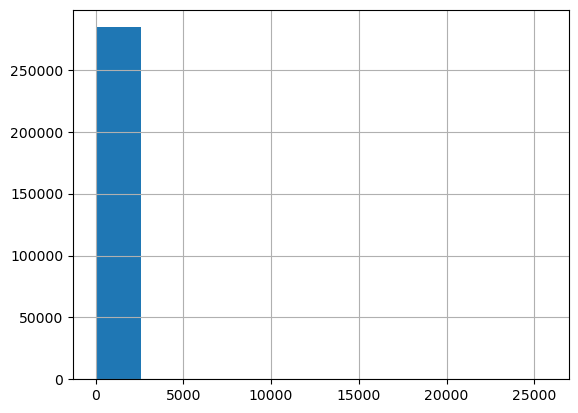

In [3]:
# severe imbalanced dataset
print(creditcard.Amount.value_counts(ascending=True).sort_values(ascending=False).sort_index(ascending=False).head(10))
print("Distribution of Amount:\n", creditcard.Amount.describe())
creditcard.Amount.hist()

### This showcase the outliers exist in the Amount feature, should use RobustScaler here

Distribution:
 0    284315
1       492
Name: Class, dtype: int64
The ratio between minority class and majority class:  0.0017304750013189597


<AxesSubplot:>

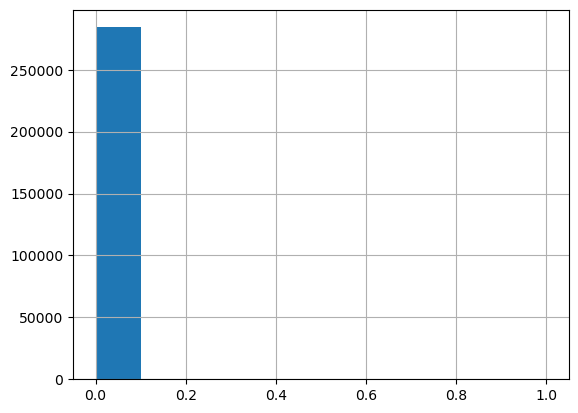

In [4]:
# severe imbalanced dataset
value_counts = creditcard.Class.value_counts()
print("Distribution:\n", value_counts)
print("The ratio between minority class and majority class: ", value_counts[1]/value_counts[0])
creditcard.Class.hist()

### This showcase the dataset is highly imbalanced, should use SMOTE here

In [5]:
""" Feature Engineering """

# Standardize dataset
std_scaler = StandardScaler()
rb_scaler = RobustScaler()

creditcard[["Time"]] = std_scaler.fit_transform(creditcard[["Time"]])
creditcard[["Amount"]] = rb_scaler.fit_transform(creditcard[["Amount"]])

# split features and label
X = creditcard.loc[:, :"Amount"].copy()
y = creditcard.loc[:, "Class"].copy()

X = np.array(X)
y = np.array(y)

# split dataset to training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# oversampling the train set
sm = SMOTE(sampling_strategy=0.015)
under = RandomUnderSampler(sampling_strategy=0.02)
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)
# X_train_res, y_train_res = X_train, y_train

unique_classes_1, counts_1 = np.unique(y_train, return_counts=True)
class_distribution_1 = dict(zip(unique_classes_1, counts_1))
unique_classes_2, counts_2 = np.unique(y_train_res, return_counts=True)
class_distribution_2 = dict(zip(unique_classes_2, counts_2))
print("Class distribution of train set before resampling:\n", class_distribution_1)
print("Class distribution of train set after resampling:\n", class_distribution_2)

Class distribution of train set before resampling:
 {0: 199020, 1: 344}
Class distribution of train set after resampling:
 {0: 149250, 1: 2985}


### This plot the distribution of two features V14 and V17 in feature space

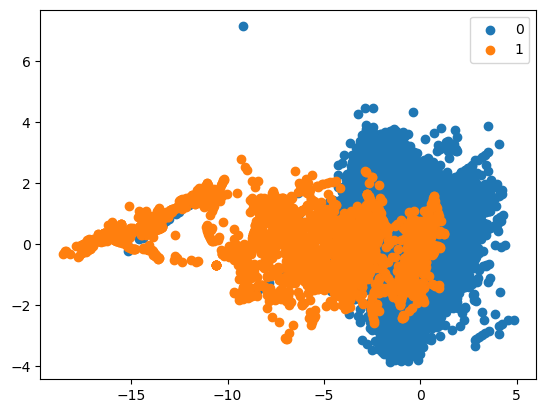

In [6]:
from matplotlib import pyplot
from numpy import where
from collections import Counter

counter = Counter(y_train_res)

X1 = np.array(X_train_res[:, 12:14])
y1 = np.array(y_train_res)

for label, _ in counter.items():
    row_ix = where(y1 == label)[0]
    pyplot.scatter(X1[row_ix, 0], X1[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [7]:
""" Split dataset into three different data domain """

# Three domains: Digital transaction division, Retail treansaction division, Fraud prevention division
digital_transactrion = X_train_res[:, :10]
retail_transaction = X_train_res[:, 10:20]
fraud_prevention = X_train_res[:, 20:]

# create three test set based on x_test
digital_transactrion_test = X_test[:, :10]
retail_transaction_test = X_test[:, 10:20]
fraud_prevention_test = X_test[:, 20:]

# save the dataframes to csv files
np.save(dataDir/'CreditCard/digital_transaction_train.npy', digital_transactrion)
np.save(dataDir/'CreditCard/retail_transaction_train.npy', retail_transaction)
np.save(dataDir/'CreditCard/fraud_prevention_train.npy', fraud_prevention)
np.save(dataDir/'CreditCard/labels_train.npy', y_train_res)

# save the dataframes to csv files
np.save(dataDir/'CreditCard/digital_transactrion_test.npy', digital_transactrion_test)
np.save(dataDir/'CreditCard/retail_transaction_test.npy', retail_transaction_test)
np.save(dataDir/'CreditCard/fraud_prevention_test.npy', fraud_prevention_test)
np.save(dataDir/'CreditCard/labels_test.npy', y_test)

digital_transactrion.shape

(152235, 10)

In [8]:
class CreditCardDataLoader(Dataset):
    """CreditCardDataLoader dataloader for credit card dataset

    Args:
        digitial_transaction (pd.DataFrame): Dataframe of digital transaction records
        retail_transaction (pd.DataFrame): Dataframe of retail transaction records
        fraud_prevention (pd.DataFrame): Dataframe of fraud prevention records
        label (pd.Series): Series of labels
    """
    def __init__(self, digitial_transaction, retail_transaction, fraud_prevention, label):
        self.digitial_transaction = digitial_transaction
        self.retail_transaction = retail_transaction
        self.fraud_prevention = fraud_prevention
        self.label = label
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.digitial_transaction[idx], dtype=torch.float32),
            torch.tensor(self.retail_transaction[idx], dtype=torch.float32),
            torch.tensor(self.fraud_prevention[idx], dtype=torch.float32),
            torch.tensor(self.label[idx], dtype=torch.float32)
        )

In [25]:
class FraudNN(nn.Module):
    """FraudNN neural network for fraud detection

    Args:
        input_size: size of the input of data
        hidden_size: size of the hidden layer
        output_size: size of the output layer
        num_hidden_layers: number of hidden layers
    """
    def __init__(
            self,
            input_size: int,
            hidden_size_1: int,
            hidden_size_2: int,
            num_hidden_layers: int = 3,
            output_size: int = 2,
        ):
        super(FraudNN, self).__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size

        self.input = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size_1),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(),
        )

        # make the number of hidden dim layers configurable
        self.layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_size_2, hidden_size_2))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_size_2))
        
        # final layer
        self.out = nn.Linear(hidden_size_2, 2)

    def forward(self, digital_trans_input, retail_trans_input, fraud_prev_input):
        
        input = torch.cat([digital_trans_input, retail_trans_input, fraud_prev_input], dim=-1)
        x = self.input(input)
        for layer in self.layers:
            x = layer(x)

        return self.out(x)

def binary_acc(y_pred, y_test):
    acc = 0.0
    y_pred_label = torch.softmax(y_pred, dim=1)
    _, y_pred_label = torch.max(y_pred_label, dim=1)
    correct_pred = (y_pred_label == y_test).sum()
    acc = correct_pred.item()/y_test.shape[0]
    return acc  

In [32]:
learning_rate = 1e-4
num_epochs = 25
batch_size = 256

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# set up input size as the sum of the feature of three domains dataset
input_size = digital_transactrion.shape[1] + retail_transaction.shape[1] + fraud_prevention.shape[1]

# create dataloader
dataset = CreditCardDataLoader(digital_transactrion, retail_transaction, fraud_prevention, label=y_train_res)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("test")
# create model
model = FraudNN(input_size=input_size, hidden_size_1=64, hidden_size_2=32)
model = model.to(device)
print(model)

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# create loss function
criterion = nn.CrossEntropyLoss()

# train model
print("Start training...\n")
model.train()

for epoch in tqdm(range(num_epochs)):    
    epoch_loss = 0.0
    epoch_acc = 0.0
    for digital_batch, retail_batch, fraud_batch, label_batch in dataloader:
        digital_batch = digital_batch.to(device)
        retail_batch = retail_batch.to(device)
        fraud_batch = fraud_batch.to(device)
        label_batch = label_batch.to(device)
        optimizer.zero_grad()
        output = model(digital_batch, retail_batch, fraud_batch)
        loss = criterion(output, label_batch.long())
        acc = binary_acc(output, label_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
    print(f'Epoch {epoch+1} loss: {epoch_loss/(len(dataloader)):.8f} acc: {epoch_acc/(len(dataloader)):.5f}')

cuda:0
test
FraudNN(
  (input): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Linear(in_features=32, out_features=2, bias=True)
)
Start training...



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 loss: 0.62798366 acc: 0.71907
Epoch 2 loss: 0.29403597 acc: 0.98932
Epoch 3 loss: 0.12983085 acc: 0.99406
Epoch 4 loss: 0.07261926 acc: 0.99490
Epoch 5 loss: 0.05182860 acc: 0.99458
Epoch 6 loss: 0.03698735 acc: 0.99530
Epoch 7 loss: 0.02865904 acc: 0.99576
Epoch 8 loss: 0.02303892 acc: 0.99580
Epoch 9 loss: 0.01929263 acc: 0.99610
Epoch 10 loss: 0.01686983 acc: 0.99645
Epoch 11 loss: 0.01419427 acc: 0.99646
Epoch 12 loss: 0.01366045 acc: 0.99685
Epoch 13 loss: 0.01259611 acc: 0.99692
Epoch 14 loss: 0.01030457 acc: 0.99730
Epoch 15 loss: 0.00966684 acc: 0.99734
Epoch 16 loss: 0.00836464 acc: 0.99775
Epoch 17 loss: 0.00802209 acc: 0.99769
Epoch 18 loss: 0.00736290 acc: 0.99781
Epoch 19 loss: 0.00700652 acc: 0.99792
Epoch 20 loss: 0.00637463 acc: 0.99811
Epoch 21 loss: 0.00559434 acc: 0.99827
Epoch 22 loss: 0.00573966 acc: 0.99834
Epoch 23 loss: 0.00503381 acc: 0.99836
Epoch 24 loss: 0.00479701 acc: 0.99847
Epoch 25 loss: 0.00463695 acc: 0.99851


In [36]:
# save model
torch.save(model.state_dict(), 'fraud_detection_sm_un.pt')

In [33]:
# load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# input_size = digital_transactrion.shape[1] + retail_transaction.shape[1] + fraud_prevention.shape[1]
# model = FraudNN(input_size=input_size, hidden_size_1=64, hidden_size_2=32)
# model.load_state_dict(torch.load('fraud_detection_sm_un.pt'))
# model = model.to(device)

unique_classes, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique_classes, counts))
print("Class distribution of test set:\n", class_distribution)

# create test dataset
test_dataset = CreditCardDataLoader(digital_transactrion_test, retail_transaction_test, fraud_prevention_test, label=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# test model and create confusion matrix
y_pred = []
y_true = []
model.eval()
test_acc = 0.0
with torch.no_grad():
    for digital_batch, retail_batch, fraud_batch, label_batch in test_dataloader:
        digital_batch = digital_batch.to(device)
        retail_batch = retail_batch.to(device)
        fraud_batch = fraud_batch.to(device)
        label_batch = label_batch.to(device)
        output = model(digital_batch, retail_batch, fraud_batch)
        acc = binary_acc(output, label_batch.long())
        test_acc += acc
        
        # save the prediction
        y_pred_label = torch.softmax(output, dim=1)
        _, y_pred_label = torch.max(y_pred_label, dim = 1)
        y_pred.extend(y_pred_label.tolist())
        y_true.extend(label_batch.long().tolist())
        
        
print(f'Test acc: {test_acc/len(test_dataloader):.4f}')

confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("ROC AUC Score: ", roc_auc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

cuda:0
Class distribution of test set:
 {0: 85295, 1: 148}
Test acc: 0.9994
ROC AUC Score:  0.9356290885527652
Precision:  0.80625
Recall:  0.8716216216216216
F1 Score:  0.8376623376623377


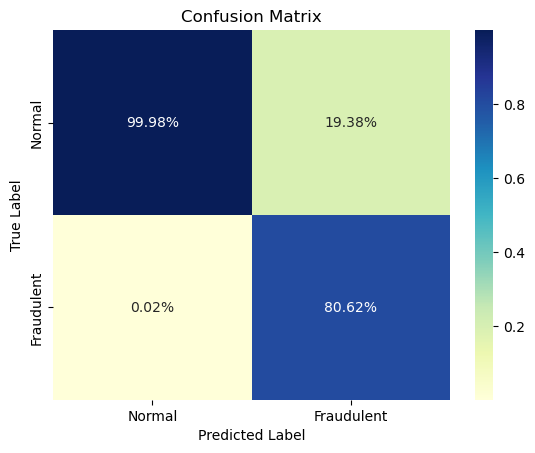

In [35]:
class_def = {0 : "Normal", 1 : "Fraudulent"}
cm_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=class_def, index=class_def)
cm_df = cm_df / np.sum(cm_df)
sns.heatmap(cm_df, annot=True, fmt='0.2%', cmap="YlGnBu").set(title="Confusion Matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.81      0.87      0.84       148

    accuracy                           1.00     85443
   macro avg       0.90      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443

